## Chapter 27 Save Models and Make Predictions

#### Process for Making a Prediction

Once you can build and tune forecast models for your data, the process of making a prediction involves the following steps:
1. Model Selection. This is where you choose a model and gather evidence and support to defend the decision.
2. Model Finalization. The chosen model is trained on all available data and saved to file for later use.
3. Forecasting. The saved model is loaded and used to make a forecast.
4. Model Update. Elements of the model are updated in the presence of new observations.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
series = pd.read_csv('data/daily-total-female-births.csv', index_col=0, parse_dates=True)
series.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


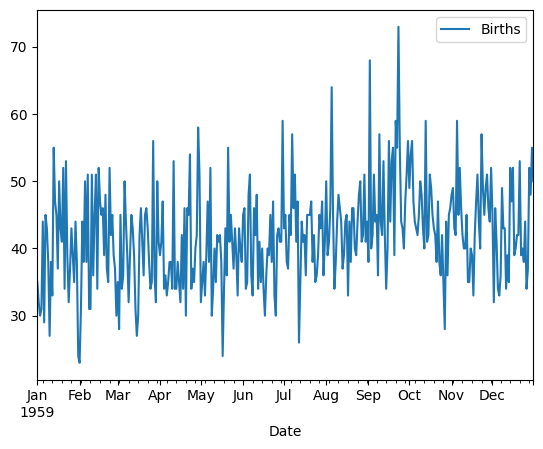

In [6]:
series.plot()
plt.show()

#### Select Time Series Forecast Model



RMSE: 7.259


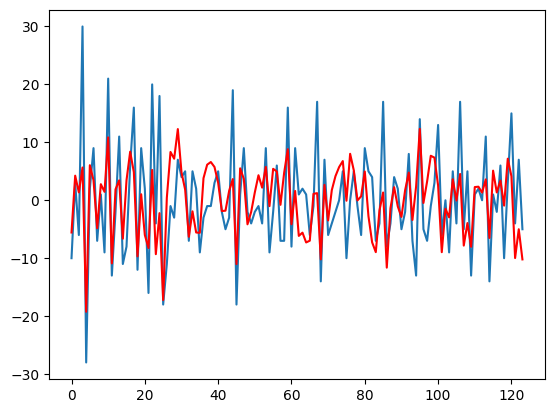

In [7]:
# fit and evaluate an AR model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# create a difference transform of the dataset
def difference(dataset):
  diff = list()
  for i in range(1, len(dataset)):
    value = dataset[i] - dataset[i - 1]
    diff.append(value)
  return np.array(diff)

# make a prediction given regression coefficients and lag obs
def predict(coef, history):
  yhat = coef[0]
  for i in range(1, len(coef)):
    yhat += coef[i] * history[-i]
  return yhat

# split dataset
X = difference(series['Births'].values)
size = int(len(X) * 0.66)
train, test = X[:size], X[size:]

# train autoregression
window = 6
model = AutoReg(train, lags=window)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
  yhat = predict(coef, history)
  obs = test[t]
  predictions.append(yhat)
  history.append(obs)
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'RMSE: {rmse:.3f}')

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

#### Finalize and Save Time Series Forecast Model

Once the model is selected, we must finalize it. This means save the salient information learned by the model so that we do not have to re-create it every time a prediction is needed. This involves first training the model on all available data and then saving the model to file.

In [8]:
# fit an AR model and save the whole model to file
X = difference(series['Births'].values)
# fit model
model = AutoReg(X, lags=6)
model_fit = model.fit()
# save model to file
model_fit.save('ar_model.pkl')
# save the differenced dataset
np.save('ar_data.npy', X)
# save the last ob
np.save('ar_obs.npy', [series['Births'].values[-1]])

In [14]:
# load the AR model from file
loaded = model_fit.load('ar_model.pkl')
print(loaded.params)
data = np.load('ar_data.npy')
last_ob = np.load('ar_obs.npy')
print(last_ob)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[50]


You can also save just the coeﬃcients from the model, as well as the minimum diﬀerenced lag values required to make the next prediction and the last observation needed to transform the next prediction
made.

In [15]:
# fit an AR model and manually save coefficients to file
X = difference(series['Births'].values)
# fit model
window_size = 6
model = AutoReg(X, lags=window_size)
model_fit = model.fit()
# save coefficients
coef = model_fit.params
np.save('man_model.npy', coef)
# save lag
lag = X[-window_size:]
np.save('man_data.npy', lag)
# save the last ob
np.save('man_obs.npy', [series['Births'].values[-1]])

In [16]:
# load the manually saved model from file
coef = np.load('man_model.npy')
print(coef)
lag = np.load('man_data.npy')
print(lag)
last_ob = np.load('man_obs.npy')
print(last_ob)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[-10   3  15  -4   7  -5]
[50]


#### Make a Time Series Forecast

In [19]:
# load AR model from file and make a one-step prediction
# load model
model = model_fit.load('ar_model.pkl')
data = np.load('ar_data.npy')
last_ob = np.load('ar_obs.npy')
# make prediction
prediction = model.predict(start=len(data), end=len(data))
# transform prediction
yhat = prediction[0] + last_ob[0]
print(f'Prediction: {yhat}')

Prediction: 46.75521111746649


In [22]:
# load coefficients from file and make a manual prediction
def predit(coef, history):
  yhat = coef[0]
  for i in range(1, len(coef)):
    yhat += coef[i] * history[-i]
  return yhat

# load model
coef = np.load('man_model.npy')
lag = np.load('man_data.npy')
last_ob = np.load('man_obs.npy')
# make prediction
prediction = predit(coef, lag)
# transform prediction
yhat = prediction + last_ob[0]
print(f'Prediction: {yhat}')

Prediction: 46.75521111746649


#### Update Forecast Model

Our work is not done. Once the next real observation is made available, we must update the
data associated with the model. Specifically, we must update:
1. The diﬀerenced training dataset used as inputs to make the subsequent prediction.
2. The last observation, providing a context for the predicted diﬀerenced value.

Let’s assume the next actual observation in the series was 48. The new observation must first be diﬀerenced with the last observation. It can then be stored in the list of diﬀerenced observations. Finally, the value can be stored as the last observation.

In [24]:
# update the data for the AR model with a new obs
# get real observation
observation = 48
# load the saved data
data = np.load('ar_data.npy')
last_ob = np.load('ar_obs.npy')
# update and save differenced observation
diffed = observation - last_ob[0]
data = np.append(data, [diffed], axis=0)
np.save('ar_data.npy', data)
# update and save real observation
last_ob[0] = observation
np.save('ar_obs.npy', last_ob)

We can make the same changes for the data files for the manual case.

In [25]:
# update the data for the manul model with a new obs
# get real observation
observation = 48
# update and save differenced observation
lag = np.load('man_data.npy')
last_ob = np.load('man_obs.npy')
diffed = observation - last_ob[0]
lag = np.append(lag[1:], [diffed], axis=0)
np.save('man_data.npy', lag)
# update and save real observation
last_ob[0] = observation
np.save('man_obs.npy', last_ob)
